## Agentic AI vs AI Agents
AI Agents
- "AI Agents" refers to individual software programs designed to perform specific tasks with a degree of autonomy (means without human intervetion)
- Functionality: AI agents handles specific tasks, limited autonomy
- Decision Making: follow predefined rules
- Example: customer service chatbot like automated banking bot which answer basic questions based on predefined knowledge like balance inquires, transactions

Agentic AI (LLM -> brain of Agentic AI)
- "Agentic AI" describes a broader framework where multiple AI agents can collaborate and make decisions independently to achieve a larger goal, emphasizing adaptability and learning from experience rather than just following predefined rules. (solve more complex workflows without human intervention)
- Functionality: Agentic AI focuses on the overall system with the ability to learn, adapt and make complex decision
- Decision Making: work on autonomous decision based on real time data and circumstances (make decison by own)
- Example: Smart home system having control of light, temperature, applicanes to have goal to reduce electricity, personalized health assistant system which analyze a patient's medical history, real-time health data, and even lifestyle factors to provide personalized care recommendations. Their ability to adapt to new mediacl research and patient feedback illustrates the higher flexibility and complexity of agentic AI
- Preception (gather the data from surrounding) -> Reasoning (Understand what is going on) -> Action (take a specific action) -> Learning (it improve and adapt over time)

## LangGraph
- LangGraph is a library for building **stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows**
- LangGraph is **DAG (Directed Acyclic Graph)** which follows sequential flow of information
- LangGraph is inspried by Pregel and Apache Beam. the public interface draws inspiration from NetworkX. 
- LangGraph is built by Langchain Inc, the creators of Langchain, but can be used without Langchain.
- LangGraph provides **fine-grained control over both the flow and state of your agent applications**
- It implements a central persistence layer, enabling features that are common to most agent architectures.
- **Memory:** LangGraph persists arbitrary aspects of your application's state, supporting memory of conversations and other updates within and across user interactions.
- **Human-in-the-loop:** because state is checkpointed, execution can be interrupted and resumed, allowing for decision, validation and corrections at key stages via human input.

### Simple Graph using LangGraph
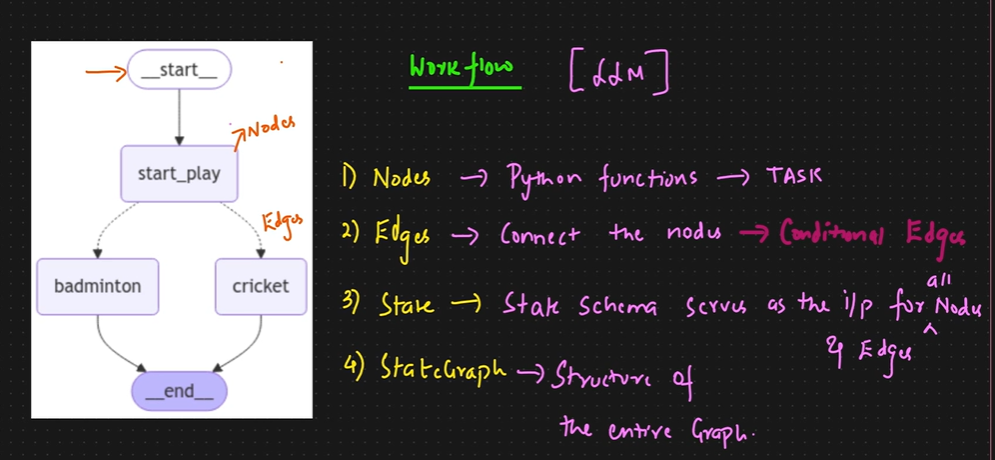

**State**

First, define the State of the Graph. The State schema serves as the input schema for all the Nodes and Edges in the graph.

In [1]:
from typing_extensions import TypedDict

# this state means whenever we are moving from one node to other, will pass this state
# TypedDict means the class will return the value in dict format
class State(TypedDict):
    graph_info: str

**Nodes**

Nodes are just python functions. The first positional argument of nodes is the State object. Because the state is a TypedDict with schema as defined above, each node can access the key graph_info with State['graph_info']. Each node returns a new value of the state key graph_info. By default, the new value returned by each node will override the prior state value.

In [2]:
def start_play(state: State):
    print("start play node is called")
    return {'graph_info':state['graph_info'] + ' I am planning to play'}

def cricket(state: State):
    print("cricket node is called")
    return {'graph_info':state['graph_info'] + ' Cricket'}

def badminton(state: State):
    print("Badminton node is called")
    return {'graph_info':state['graph_info'] + ' Badminton'}

In [3]:
import random
from typing import Literal

# conditional edge
# make sure the return is node name will be same as defined in function node
def random_play(state: State)->Literal['cricket','badminton']:
    graph_info=state['graph_info']
    if random.random()>0.5:
        return 'cricket'
    else:
        return 'badminton'

**Graph Construction**
- The "StateGraph" class is the graph class that we can use.
- First, we initialize a StateGraph with the State class we defined above.
- then, we add our Nodes and Edges.
- We use the START Node, a special node that sends user input to the graph to indicate where to start our graph.
- The END Node is a special node that represents a terminal node.
- Finally, we compile our graph to perform a few basic checks on the graph structure.
- We can visualize the graph as a "Mermaid Diagram".

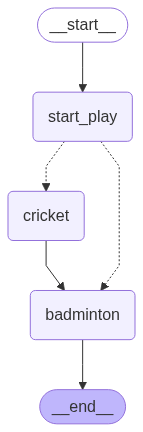

In [ ]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

# build graph
graph=StateGraph(State)

# add nodes to the graph
graph.add_node('start_play',start_play)
graph.add_node('cricket',cricket)
graph.add_node('badminton',badminton)

# add edges and flow of graph
graph.add_edge(START,'start_play')
graph.add_edge('cricket',END)
graph.add_conditional_edges('start_play',random_play)
# graph.add_edge('cricket','badminton')
graph.add_edge('badminton',END)

# compile the graph
graph_builder=graph.compile()

# view the graph created
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [15]:
# invoking the graph
# graph_builder.invoke({'graph_info':'My name is Srishti.'})
graph_builder.invoke({})

start play node is called


KeyError: 'graph_info'

### Simple Chatbot with LangGraph (LLM powered)

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END

# Reducers - here add_messages is a reducer 
from typing import Annotated
from langgraph.graph.message import add_messages

as we discussed, each node will return a new value for our state keys. but this new value will override the prior key value. As our graph runs, we want to append messages to our state key. We can use **reducer** functions to address this. 

Reducers allow us to specify how state updates are performed. We can use the pre-built *add_messages* reducer function. This ensures that any value of key are appended to existing list of key values.

In [7]:
# here we need to store conversation of user and bot
# so using Annotated which is of type list, will annotate the user and bot response
# add_messages will append each response to the list
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY2')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI

openai_llm=ChatOpenAI(model='gpt-4o')
openai_llm.invoke("hello")

In [17]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke("hey I am Srishti and i like learning new things")

AIMessage(content="Nice to meet you, Srishti. It's great that you enjoy learning new things. There's always something new to discover and explore, and I'm here to help you with that. What's something you've been interested in learning lately?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 47, 'total_tokens': 98, 'completion_time': 0.074795274, 'prompt_time': 0.066811646, 'queue_time': 0.043308794, 'total_time': 0.14160692}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2a85b31419', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1fd56fc3-69a7-4f95-a604-15df3a174ca1-0', usage_metadata={'input_tokens': 47, 'output_tokens': 51, 'total_tokens': 98})

In [18]:
# node
def superbot(state: State):
    return {"messages":[groq_llm.invoke(state['messages'])]}

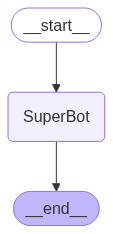

In [19]:
graph=StateGraph(State)
graph.add_node("SuperBot",superbot)
graph.add_edge(START,'SuperBot')
graph.add_edge('SuperBot',END)

graph_builder=graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [20]:
# invoking the graph
graph_builder.invoke({'messages':'Hi, My name is Srishti'})

{'messages': [HumanMessage(content='Hi, My name is Srishti', additional_kwargs={}, response_metadata={}, id='a62b9410-eb98-4ab3-90e9-f6a0bc7de920'),
  AIMessage(content='Nice to meet you, Srishti. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 43, 'total_tokens': 60, 'completion_time': 0.01703915, 'prompt_time': 0.006370856, 'queue_time': 0.050447721, 'total_time': 0.023410006}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2a85b31419', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--074b36ee-6af7-45c5-a098-11fc1fc88c94-0', usage_metadata={'input_tokens': 43, 'output_tokens': 17, 'total_tokens': 60})]}

In [21]:
# streaming the responses
# stream_mode can be 'values' and 'updates', default is 'updates'
for event in graph_builder.stream({'messages':"Hello there"},stream_mode='values'):
    print(event)

{'messages': [HumanMessage(content='Hello there', additional_kwargs={}, response_metadata={}, id='3145b69b-df3f-43bc-8090-5c74929c05bb')]}
{'messages': [HumanMessage(content='Hello there', additional_kwargs={}, response_metadata={}, id='3145b69b-df3f-43bc-8090-5c74929c05bb'), AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 37, 'total_tokens': 45, 'completion_time': 0.006064798, 'prompt_time': 0.213840362, 'queue_time': 0.043820272, 'total_time': 0.21990516}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2a85b31419', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--78c4f567-842e-499e-a0a7-760bbbe1624a-0', usage_metadata={'input_tokens': 37, 'output_tokens': 8, 'total_tokens': 45})]}
